In [44]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from nilearn import datasets
from nilearn.input_data import NiftiMasker, NiftiSpheresMasker
from nilearn.plotting import plot_roi, plot_epi, show
from nilearn.image.image import mean_img
import nilearn.image as image


Simple example of NiftiMasker use
==================================

Here is a simple example of automatic mask computation using the nifti masker.
The mask is computed and visualized.

Retrieve the brain development functional dataset



In [37]:

dev_data = datasets.fetch_development_fmri(n_subjects=1)
func_filename = dev_data.func[0]

# print basic information on the dataset
print('First functional nifti image (4D) is at: %s' % func_filename)

First functional nifti image (4D) is at: /home/strange_lorenz/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


Compute the mask

In [6]:

# As this is raw movie watching based EPI, the background is noisy and we
# cannot rely on the 'background' masking strategy. We need to use the 'epi'
# one
nifti_masker = NiftiMasker(standardize=True, mask_strategy='epi',
                           memory="nilearn_cache", memory_level=2,
                           smoothing_fwhm=8)
nifti_masker.fit(func_filename)
mask_img = nifti_masker.mask_img_

Visualize the mask using the plot_roi method


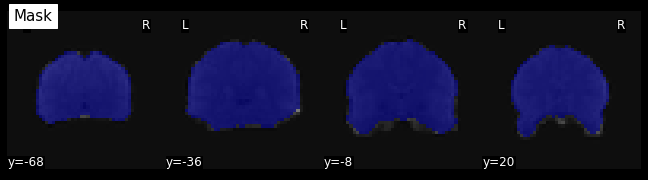

In [8]:


# calculate mean image for the background
mean_func_img = mean_img(func_filename)

plot_roi(mask_img, mean_func_img, display_mode='y', cut_coords=4, title="Mask")

Visualize the mask using the 'generate_report' method This report can be displayed in a Jupyter Notebook, opened in-browser using the .open_in_browser() method, or saved to a file using the .save_as_html(output_filepath) method

In [9]:
report = nifti_masker.generate_report()
report

Parameter,Value
detrend,False
dtype,None
high_pass,None
low_pass,None
mask_args,None
mask_img,None
mask_strategy,epi
memory,Memory(location=nilearn_cache/joblib)
memory_level,2
reports,True


Preprocess data with the NiftiMasker


In [10]:
nifti_masker.fit(func_filename)
fmri_masked = nifti_masker.transform(func_filename)
# fmri_masked is now a 2D matrix, (n_voxels x n_time_points)

In [11]:
from sklearn.decomposition import FastICA
n_components = 10
ica = FastICA(n_components=n_components, random_state=42)
components_masked = ica.fit_transform(fmri_masked.T).T

Reverse masking, and display the corresponding map



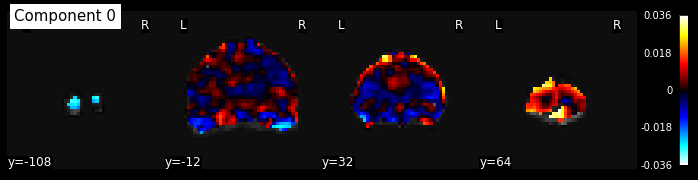

In [16]:
components = nifti_masker.inverse_transform(components_masked)

# Visualize results

# calculate mean image for the background
mean_func_img = mean_img(func_filename)

plot_stat_map(image.index_img(components, 0), mean_func_img,
              display_mode='y', cut_coords=4, title="Component 0")

show()


Understanding NiftiMasker and mask computation
==================================================

In this example, the Nifti masker is used to automatically compute a mask.

* The default strategy is based on the background.

* Another option is to use a template.

* For raw EPI, as in resting-state or movie watching time series, we need to
  use the 'epi' strategy of the NiftiMasker.

In addition, we show here how to tweak the different parameters of the
underlying routine that extract masks from EPI
:func:`nilearn.masking.compute_epi_mask`.


Computing a mask from the background
-----------------------------------------------------------

 The default strategy to compute a mask, eg in NiftiMasker is to try to
 detect the background.

 With data that has already been masked, this will work well, as it lies
 on a homogeneous background




Dataset created in /home/strange_lorenz/nilearn_data/miyawaki2008



Downloaded 161069109 of 161069109 bytes (100.0%,    0.0s remaining) ...done. (26 seconds, 0 min)
Extracting data from /home/strange_lorenz/nilearn_data/miyawaki2008/4356183cd5ae215342603c6edeb89f54/miyawaki2008.tgz..... done.


First functional nifti image (4D) is located at: /home/strange_lorenz/nilearn_data/miyawaki2008/func/data_figure_run01.nii.gz


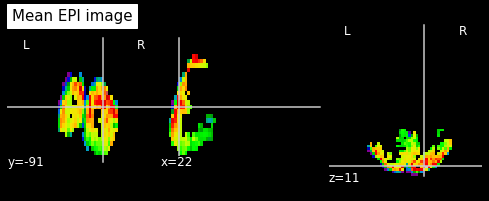

In [18]:
# Load Miyawaki dataset
from nilearn import datasets
miyawaki_dataset = datasets.fetch_miyawaki2008()

# print basic information on the dataset
print('First functional nifti image (4D) is located at: %s' %
      miyawaki_dataset.func[0])  # 4D data

miyawaki_filename = miyawaki_dataset.func[0]
miyawaki_mean_img = image.mean_img(miyawaki_filename)
plot_epi(miyawaki_mean_img, title='Mean EPI image')

A NiftiMasker with the default strategy

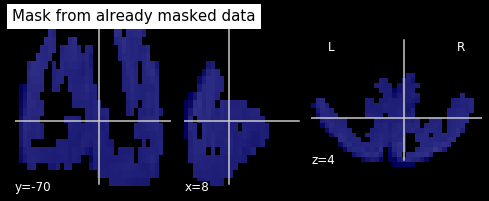

In [23]:
masker = NiftiMasker()
masker.fit(miyawaki_filename)

# Plot the generated mask using the mask_img_ attribute
plot_roi(masker.mask_img_, miyawaki_mean_img,
         title="Mask from already masked data")

In [24]:
report = masker.generate_report()
report

Parameter,Value
detrend,False
dtype,None
high_pass,None
low_pass,None
mask_args,None
mask_img,None
mask_strategy,background
memory,Memory(location=None)
memory_level,1
reports,True


Computing a mask from raw EPI data
------

From raw EPI data, there is no uniform background, and a different strategy is necessary

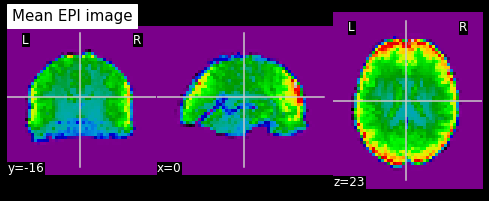

In [25]:
# Load movie watching based brain development fmri dataset
dataset = datasets.fetch_development_fmri(n_subjects=1)
epi_filename = dataset.func[0]

# Restrict to 100 frames to speed up computation
from nilearn.image import index_img
epi_img = index_img(epi_filename, slice(0, 100))

# To display the background
mean_img = image.mean_img(epi_img)
plot_epi(mean_img, title='Mean EPI image')

Simple mask extraction from EPI images
We need to specify an 'epi' mask_strategy, as this is raw EPI data

In [29]:
masker = NiftiMasker(mask_strategy='epi')
masker.fit(epi_img)
report = masker.generate_report()
report

Parameter,Value
detrend,False
dtype,None
high_pass,None
low_pass,None
mask_args,None
mask_img,None
mask_strategy,epi
memory,Memory(location=None)
memory_level,1
reports,True


Generate mask with strong opening

We can fine-tune the outline of the mask by increasing the number of
opening steps (`opening=10`) using the `mask_args` argument of the
NiftiMasker. This effectively performs erosion and dilation
operations on the outer voxel layers of the mask, which can for example
remove remaining
skull parts in the image.


In [28]:
masker = NiftiMasker(mask_strategy='epi', mask_args=dict(opening=10))
masker.fit(epi_img)
report = masker.generate_report()
report

Parameter,Value
detrend,False
dtype,None
high_pass,None
low_pass,None
mask_args,{'opening': 10}
mask_img,None
mask_strategy,epi
memory,Memory(location=None)
memory_level,1
reports,True


Generate mask with a high lower cutoff

The NiftiMasker calls the nilearn.masking.compute_epi_mask function to
compute the mask from the EPI. It has two important parameters:
lower_cutoff and upper_cutoff. These set the grey-value bounds in which
the masking algorithm will search for its threshold (0 being the
minimum of the image and 1 the maximum). We will here increase the
lower cutoff to enforce selection of those voxels that appear as bright
in the EPI image.



In [31]:
masker = NiftiMasker(mask_strategy='epi',
                     mask_args=dict(upper_cutoff=.9, lower_cutoff=.8,
                                    opening=False))
masker.fit(epi_img)
report = masker.generate_report()
report

Parameter,Value
detrend,False
dtype,None
high_pass,None
low_pass,None
mask_args,"{'upper_cutoff': 0.9, 'lower_cutoff': 0.8, 'opening': False}"
mask_img,None
mask_strategy,epi
memory,Memory(location=None)
memory_level,1
reports,True


Computing the mask from the MNI template
##############################################################################

 A mask can also be computed from the MNI gray matter template. In this
 case, it is resampled to the target image



In [32]:
masker = NiftiMasker(mask_strategy='template')
masker.fit(epi_img)
report = masker.generate_report()
report

Parameter,Value
detrend,False
dtype,None
high_pass,None
low_pass,None
mask_args,None
mask_img,None
mask_strategy,template
memory,Memory(location=None)
memory_level,1
reports,True


Compute and resample a mask
--------

 NiftiMasker also allows passing parameters directly to `image.resample_img`.
 We can specify a `target_affine`, a `target_shape`, or both.
 For more information on these arguments,
 see :doc:`plot_affine_transformation`.

 The NiftiMasker report allows us to see the mask before and after resampling.
 Simply hover over the report to see the mask from the original image.



In [33]:
import numpy as np

masker = NiftiMasker(mask_strategy='epi', target_affine=np.eye(3) * 8)
masker.fit(epi_img)
report = masker.generate_report()
report

Parameter,Value
detrend,False
dtype,None
high_pass,None
low_pass,None
mask_args,None
mask_img,None
mask_strategy,epi
memory,Memory(location=None)
memory_level,1
reports,True


After mask computation: extracting time series
------------------

Extract time series

In [35]:
# trended vs detrended
trended = NiftiMasker(mask_strategy='epi')
detrended = NiftiMasker(mask_strategy='epi', detrend=True)
trended_data = trended.fit_transform(epi_img)
detrended_data = detrended.fit_transform(epi_img)

# The timeseries are numpy arrays, so we can manipulate them with numpy

print("Trended: mean %.2f, std %.2f" %
      (np.mean(trended_data), np.std(trended_data)))
print("Detrended: mean %.2f, std %.2f" %
      (np.mean(detrended_data), np.std(detrended_data)))

show()

Trended: mean 552.82, std 168.28
Detrended: mean -0.00, std 5.88



Producing single subject maps of seed-to-voxel correlation
==========================================================

This example shows how to produce seed-to-voxel correlation maps for a single
subject based on movie-watching fMRI scans.
These maps depict the temporal correlation of a **seed region** with the
**rest of the brain**.

This example is an advanced one that requires manipulating the data with numpy.
Note the difference between images, that lie in brain space, and the
numpy array, corresponding to the data inside the mask.

See also `for a similar example using cortical surface input data
<sphx_glr_auto_examples_01_plotting_plot_surf_stat_map.py>`.


In [38]:
func_filename = dev_data.func[0]
confound_filename = dataset.confounds[0]
print(func_filename)
print(confound_filename)

/home/strange_lorenz/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
/home/strange_lorenz/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_desc-reducedConfounds_regressors.tsv


Time series extraction
----------------------

We are going to extract signals from the functional time series in two
steps. First we will extract the mean signal within the **seed region of
interest**. Second, we will extract the **brain-wide voxel-wise time series**.

We will be working with one seed sphere in the Posterior Cingulate Cortex
(PCC), considered part of the Default Mode Network.



In [39]:
pcc_coords = [(0, -52, 18)]

We use :class:`nilearn.input_data.NiftiSpheresMasker` to extract the
**time series from the functional imaging within the sphere**. The
sphere is centered at pcc_coords and will have the radius we pass the
NiftiSpheresMasker function (here 8 mm).

The extraction will also detrend, standardize, and bandpass filter the data.
This will create a NiftiSpheresMasker object.

We use :class:`nilearn.input_data.NiftiSpheresMasker` to extract the
**time series from the functional imaging within the sphere**. The
sphere is centered at pcc_coords and will have the radius we pass the
NiftiSpheresMasker function (here 8 mm).

The extraction will also detrend, standardize, and bandpass filter the data.
This will create a NiftiSpheresMasker object.

In [45]:
seed_masker = NiftiSpheresMasker(
    pcc_coords, radius=8,
    detrend=True, standardize=True,
    low_pass=0.1, high_pass=0.01, t_r=2,
    memory='nilearn_cache', memory_level=1, verbose=0)

Then we extract the mean time series within the seed region while
regressing out the confounds that
can be found in the dataset's csv file



In [46]:
seed_time_series = seed_masker.fit_transform(func_filename,
                                             confounds=[confound_filename])

Next, we can proceed similarly for the brain-wide voxel-wise time series, using :class:nilearn.input_data.NiftiMasker with the same input arguments as in the seed_masker in addition to smoothing with a 6 mm kernel

Then we extract the brain-wide voxel-wise time series while regressing out the confounds as before

In [50]:
brain_masker = NiftiMasker(
    smoothing_fwhm=6,
    detrend=True, standardize=True,
    low_pass=0.1, high_pass=0.01, t_r=2,
    memory='nilearn_cache', memory_level=1, verbose=0)

brain_time_series = brain_masker.fit_transform(func_filename,
                                               confounds=[confound_filename])

We can now inspect the extracted time series. Note that the **seed time
series** is an array with shape n_volumes, 1), while the
**brain time series** is an array with shape (n_volumes, n_voxels).


In [52]:
print("Seed time series shape: (%s, %s)" % seed_time_series.shape)
print("Brain time series shape: (%s, %s)" % brain_time_series.shape)

Seed time series shape: (168, 1)
Brain time series shape: (168, 32504)


We can plot the **seed time series**.


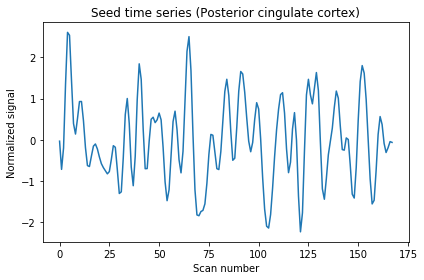

In [54]:
import matplotlib.pyplot as plt

plt.plot(seed_time_series)
plt.title('Seed time series (Posterior cingulate cortex)')
plt.xlabel('Scan number')
plt.ylabel('Normalized signal')
plt.tight_layout()
plt.plot(seed_time_series)
plt.title('Seed time series (Posterior cingulate cortex)')
plt.xlabel('Scan number')
plt.ylabel('Normalized signal')
plt.tight_layout()

Exemplarily, we can also select 5 random voxels from the brain-wide data and plot the time series from

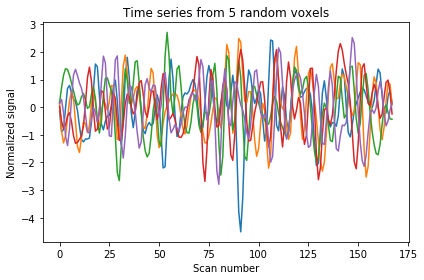

In [55]:
plt.plot(brain_time_series[:, [10, 45, 100, 5000, 10000]])
plt.title('Time series from 5 random voxels')
plt.xlabel('Scan number')
plt.ylabel('Normalized signal')
plt.tight_layout()

Performing the seed-to-voxel correlation analysis
-------------------------------------------------

Now that we have two arrays (**sphere signal**: (n_volumes, 1),
**brain-wide voxel-wise signal** (n_volumes, n_voxels)), we can correlate
the **seed signal** with the **signal of each voxel**. The dot product of
the two arrays will give us this correlation. Note that the signals have
been variance-standardized during extraction. To have them standardized to
norm unit, we further have to divide the result by the length of the time
series.



In [56]:
import numpy as np

seed_to_voxel_correlations = (np.dot(brain_time_series.T, seed_time_series) /
                              seed_time_series.shape[0]
                              )

The resulting array will contain a value representing the correlation
values between the signal in the **seed region** of interest and **each
voxel's signal**, and will be of shape (n_voxels, 1). The correlation
values can potentially range between -1 and 1.



In [58]:
print("Seed-to-voxel correlation shape: (%s, %s)" %
      seed_to_voxel_correlations.shape)
print("Seed-to-voxel correlation: min = %.3f; max = %.3f" % (
    seed_to_voxel_correlations.min(), seed_to_voxel_correlations.max()))

Seed-to-voxel correlation shape: (32504, 1)
Seed-to-voxel correlation: min = -0.624; max = 0.958


Plotting the seed-to-voxel correlation map
------------------------------------------
We can now plot the seed-to-voxel correlation map and perform thresholding
to only show values more extreme than +/- 0.5. Before displaying,
we need to create an in memory Nifti image object.
Furthermore, we can display the location of the seed with a sphere and
set the cross to the center of the seed region of interest.



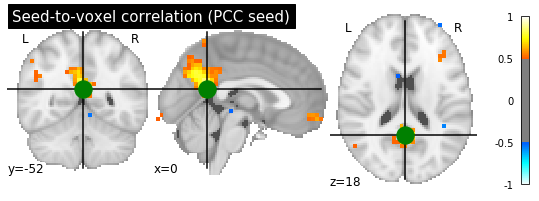

In [59]:
from nilearn import plotting

seed_to_voxel_correlations_img = brain_masker.inverse_transform(
    seed_to_voxel_correlations.T)
display = plotting.plot_stat_map(seed_to_voxel_correlations_img,
                                 threshold=0.5, vmax=1,
                                 cut_coords=pcc_coords[0],
                                 title="Seed-to-voxel correlation (PCC seed)"
                                 )
display.add_markers(marker_coords=pcc_coords, marker_color='g',
                    marker_size=300)
# At last, we save the plot as pdf.
display.savefig('pcc_seed_correlation.pdf')

Fisher-z transformation and save nifti
--------------------------------------
Finally, we can Fisher-z transform the data to achieve a normal distribution.
The transformed array can now have values more extreme than +/- 1.



In [60]:
seed_to_voxel_correlations_fisher_z = np.arctanh(seed_to_voxel_correlations)
print("Seed-to-voxel correlation Fisher-z transformed: min = %.3f; max = %.3f"
      % (seed_to_voxel_correlations_fisher_z.min(),
         seed_to_voxel_correlations_fisher_z.max()
         )
      )

# Finally, we can tranform the correlation array back to a Nifti image
# object, that we can save.
seed_to_voxel_correlations_fisher_z_img = brain_masker.inverse_transform(
    seed_to_voxel_correlations_fisher_z.T)
seed_to_voxel_correlations_fisher_z_img.to_filename(
    'pcc_seed_correlation_z.nii.gz')


Seed-to-voxel correlation Fisher-z transformed: min = -0.731; max = 1.927



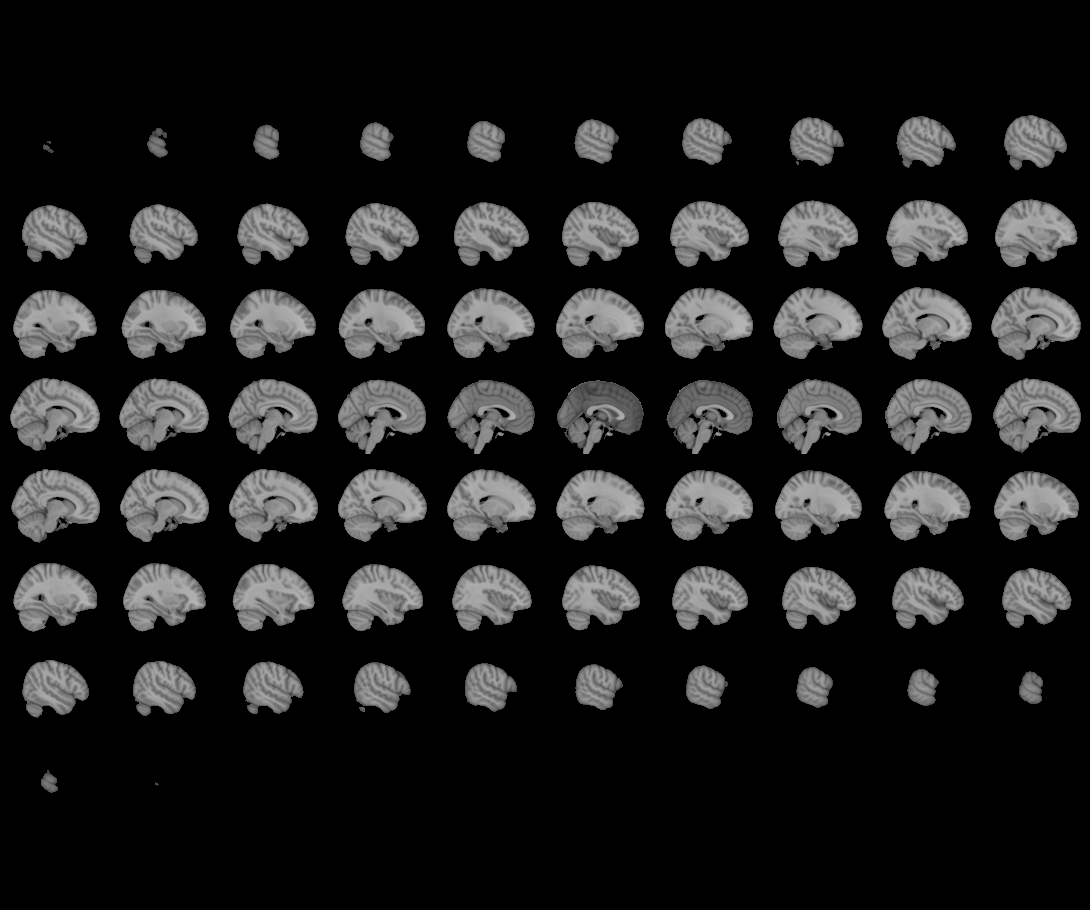
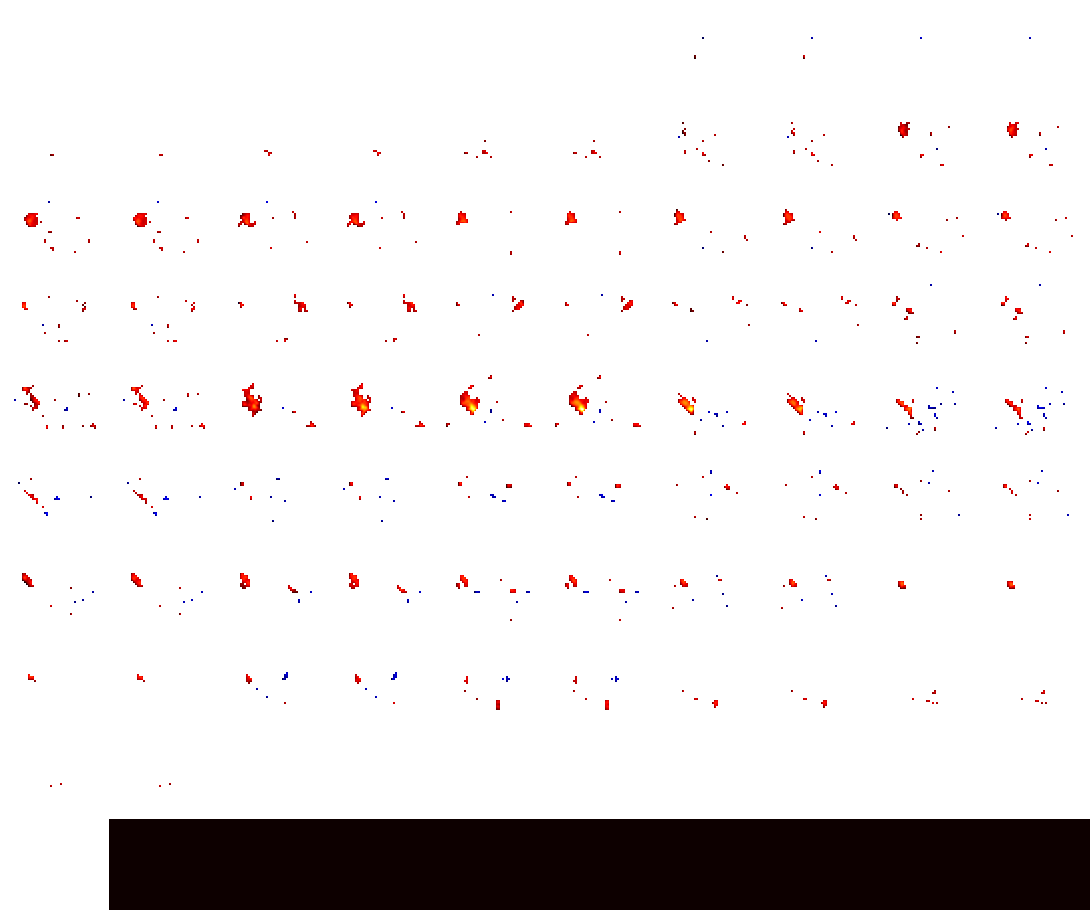

In [74]:

plotting.view_img(seed_to_voxel_correlations_fisher_z_img, threshold=0.5,
                                   title="Correlation Z") 